# Regression Analysis with the Boston Housing Dataset in Keras

In this notebook we will cover the following issues:

* How to create a simple regressor NN model and work with continuous numerical data
* Using K-Fold cross-validation in order to get more general results for our models (Sklearn library used for that)
    * Generally, we will use 10-Fold cross-validation as 9 fold for training, and 1 fold for validation-set.;
<img src="images/KFoldCrossValidation.png" width=600 height=400>
    
* Mean Squared Error (MSE) and Mean Absolute Error (MAE)
    * We can use both of them as loss function, and evaluation matrices for regression analysis;
    * Formulas;
<img src="images/MSE.png" width=400 height=400>   

* Vusualizing and observing feature correlation on heatmap
* Feature Selection for more generalized data

### Required Modules

In [1]:
from keras.datasets import boston_housing
import numpy as np
from keras import models, layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

### Loading and Exploring Dataset

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


* In this case, we have a limited dataset 404 samples for training and 102 samples for testing.

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

* Labels consist of prices of the houses in Boston in the mid of 1970s.
* They were written in short form like 50, which represents 50000$.

In [5]:
train_labels[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### Normalizing Data

* StandardScaler in Scikit-learn library normalizes data in feature-based instead of sample base.

In [6]:
std = StandardScaler()

train_data = std.fit_transform(train_data)
test_data = std.transform(test_data)

In [7]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

* Before start the fitting process of the model, let's separate 100 samples as validation data from the training

In [ ]:
X_train = train_data[100:]
y_train = train_labels[100:]
X_val = train_data[:100]
y_val = train_labels[:100]

### Building and Fitting Model

Since we will be using the same model many times later, we have built it inside a function:

* Our model consists of 4 hidden layers with 128, 64, 16, and 4 units. Rectified Linear Unit `ReLu` activation function is used.
* `Rmsprop` is used as the optimizer. However, you might try `Adam` or `SGD` as well. Besides, we can count `Tanh` activation as another option.

In [ ]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(4, activation='relu'))
  model.add(layers.Dense(1)) # For regression, there is no activation function 
                             # and a single unit should be used in the layer.

  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [ ]:
model = build_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=4, validation_data=(X_val, y_val))

Epoch 1/20
76/76 [==============================] - 0s 6ms/step - loss: 200.7920 - mae: 10.9542 - val_loss: 34.8257 - val_mae: 3.9821
Epoch 2/20
76/76 [==============================] - 0s 2ms/step - loss: 31.2657 - mae: 3.9388 - val_loss: 22.4652 - val_mae: 3.3547
Epoch 3/20
76/76 [==============================] - 0s 3ms/step - loss: 21.0626 - mae: 3.1302 - val_loss: 16.4121 - val_mae: 2.8201
Epoch 4/20
76/76 [==============================] - 0s 3ms/step - loss: 18.1595 - mae: 2.8867 - val_loss: 15.8029 - val_mae: 2.7889
Epoch 5/20
76/76 [==============================] - 0s 3ms/step - loss: 15.7975 - mae: 2.7387 - val_loss: 11.3968 - val_mae: 2.2820
Epoch 6/20
76/76 [==============================] - 0s 3ms/step - loss: 13.4953 - mae: 2.5800 - val_loss: 11.2366 - val_mae: 2.2701
Epoch 7/20
76/76 [==============================] - 0s 4ms/step - loss: 13.4130 - mae: 2.5274 - val_loss: 9.8178 - val_mae: 2.1030
Epoch 8/20
76/76 [==============================] - 0s 3ms/step - loss: 12.

* At the end of 20 epoch, we got roughly 1.97 validation mean absolute error, which equivalent to 1970\\$ error in the validation set.
* However, in the test case, we have a 2720\\$ error. That makes a 750\\$ gap between validation and test scores. That means the model tends to overfit the validation set.

In [ ]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 2ms/step - loss: 19.0536 - mae: 2.7212


[19.053613662719727, 2.7211787700653076]

### Validating Model Using KFold

* Previously, we used 100 samples as validation data, and we observed that data tends to overfit validation data. During K-Fold, we are splitting data in 10 portion that makes 364 training and 40 test sample for each fold.
* Now, let's use 10-Fold cross-validation to obtain average test error

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
val_scores = []
test_scores = []

for train_index, test_index in kf.split(train_data, train_labels):
  X_train, X_val = train_data[train_index], train_data[test_index]
  y_train, y_val = train_labels[train_index], train_labels[test_index]

  model = build_model()
  history = model.fit(X_train, y_train, epochs=20, batch_size=4, verbose=0, validation_data=(X_val, y_val))
  val_scores.append(history.history['val_mae'][-1])
  test_scores.append(model.evaluate(test_data, test_labels)[1])

4/4 [==============================] - 0s 3ms/step - loss: 18.6407 - mae: 2.7264


As a new result, we have a 500\\$ gap between validation and test data since we have decreased the amount of validation data.

In [ ]:
np.mean(np.abs(np.ravel(test_scores)-np.ravel(val_scores)))

0.5034162402153015

* We have roughly 2850\\$ test error on average. That means we hurt the test performance a bit.

In [ ]:
np.mean(test_scores)

2.8533445835113525

Now, since we have limited data, let's repeat the same process without using validation data. But in this case, we will concatenate the train and test samples in order to evaluate our model with a different portion of the whole data-set using 5-fold cross-validation.

The main reason we chose 5-fold cross-validation is 1 portion of it comes across almost 100 samples as test data, which is the same amount as the previous case.

In [ ]:
X = np.concatenate((train_data, test_data), axis=0)
y = np.concatenate((train_labels, test_labels), axis=0)

In [ ]:
X.shape

(506, 13)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_index, test_index in kf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model = build_model()
  model.fit(X_train, y_train, epochs=20, batch_size=4, verbose=0)
  scores.append(model.evaluate(X_test, y_test)[1])

4/4 [==============================] - 0s 2ms/step - loss: 10.5325 - mae: 2.4890


In [ ]:
scores

[2.794982671737671,
 2.3391175270080566,
 2.690911054611206,
 2.5324416160583496,
 2.4890496730804443]

Now, we have obtained a 2.57 MAE score and 2570\\$ overall deviation which is better than our previous cases.

In [ ]:
np.mean(scores)

2.5693005084991456

### One More Thing!

In Kaggle's competition of [Boston Housing](https://www.kaggle.com/c/boston-housing/overview), they were looking at Root Mean Squared Error `RMSE`. Let's change our evaluation matrices as RMSE and re-train our model.

* For the formula of RMSE;

<img src="images/RMSE.png" width=480 height=360>

In [17]:
from keras import backend as K
import tensorflow as tf

@tf.function
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(4, activation='relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer='rmsprop', loss='mse', metrics=RMSE)
  return model

Since TensorFlow creates randomly initialized weights each time, let's repeat the training process 10 times and take the mean of them.

In [18]:
rmse_scores = []
for step in range(10):
  model = build_model()
  model.fit(train_data, train_labels, epochs=20, batch_size=4, verbose=0)
  rmse_scores.append(model.evaluate(test_data, test_labels)[1])

4/4 [==============================] - 0s 2ms/step - loss: 20.3492 - RMSE: 2.6892


In [19]:
print('RMSE Score:',np.mean(rmse_scores))

RMSE Score: 2.8044910430908203


We got a 2.8 RMSE score on average, which places us within the top 5 in the leaderboard even without making any feature engineering.

### Future Engineering


#### Feature Correlations

Observing the correlation between parameters is important to detect useful ones, and eliminate others, which add some bias, and may mislead the model. For this reason, the heatmap of the correlation between parameters is plotted below. In order to observe better the relationship between output and parameters, targets are also inserted inside correlation as the 13th index. Thus, we can select the most correlated columns with targets.

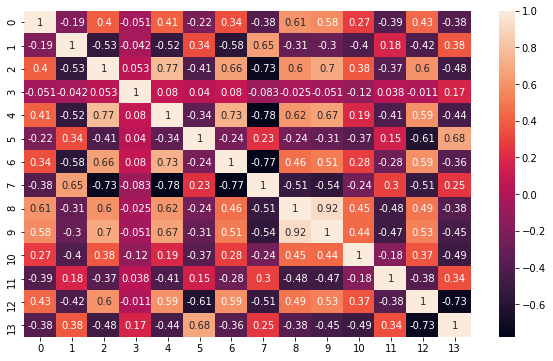

In [20]:
combined_train = np.concatenate((train_data, train_labels.reshape((-1,1))), axis=1)
df = pd.DataFrame(combined_train)

fig = plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

When we look at the 13th row, the 12th parameter seems the strongest-correlated one negatively, then the 5th column following it. Also, we should exclude highly correlated features since they yield variance, and models will be highly sensitive to training data. But, we should generalize it to get a better score on test data. For instance, the 8th and 9th features have a 0.92 correlation, which is pretty high. In this case, we can extract the 8th parameter since the 9th one is more correlated with the target.

#### Feature Selection

After all, it is may hard to detect all anomalies from correlations. For this reason, we may use feature selection techniques with a Random Forest algorithm in Sklearn library, which is quite popular in the ML area.

10000 estimators are used for training RandomForesRegressor model. Then, importances of features are returned by `feature_importances_` attribute.

In [8]:
rf = RandomForestRegressor(n_estimators=10000, n_jobs=-1)
rf.fit(train_data, train_labels)
feature_importance = rf.feature_importances_

You can see the probability of feature importances, and corresponding indices in sorted order below. For this case, we will only consider the first 9 features since others have less than 1% importance.

In [9]:
sorted(feature_importance, reverse=True)

[0.41543101047382563,
 0.38765565617116654,
 0.06695360817617603,
 0.04643026292834846,
 0.018391822652997856,
 0.016937947022275624,
 0.014196346454481033,
 0.011876463158528007,
 0.010789064707926142,
 0.005342345252706388,
 0.004075733256904156,
 0.001021874334716227,
 0.0008978654099477418]

In [23]:
sorted_idxs = np.argsort(feature_importance)[::-1]
sorted_idxs

array([12,  5,  7,  0,  4,  6, 10,  9, 11,  8,  2,  3,  1])

In [62]:
from keras import backend as K
import tensorflow as tf

@tf.function
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(128, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(4, activation='relu'))
  model.add(layers.Dense(1))

  model.compile(optimizer='rmsprop', loss='mse', metrics=RMSE)
  return model

In [64]:
rmse_scores = []
for step in range(10):
  model = build_model()
  model.fit(train_data[:, sorted_idxs[:9]], train_labels, epochs=20, batch_size=4, verbose=0)
  rmse_scores.append(model.evaluate(test_data[:, sorted_idxs[:9]], test_labels)[1])

4/4 [==============================] - 0s 2ms/step - loss: 17.1858 - RMSE: 2.7560


In [65]:
print('RMSE Score:',np.mean(rmse_scores))

RMSE Score: 2.668097186088562


Now, we got a better RMSE score than ever.